In [58]:
import os
import time
import pypianoroll
from pypianoroll import Multitrack, Track
import torch.utils.data as Data
from matplotlib import pyplot as plt
from vae_rnn import *

In [59]:
'''
laod model
'''
path = os.getcwd() + '/models/'
model = [ m for m in os.listdir(path) if '.pt' in m ][0]
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)
vae.load_state_dict(torch.load(path + model))

In [60]:
'''
load data
'''
genres = [x for x in os.listdir('./../explore_data/data/') if '.npy' in x]
train_x_np = np.load('./../explore_data/data/' + genres[2])
train_x = torch.from_numpy(train_x_np).type(torch.FloatTensor)
train_dataset = Data.TensorDataset(train_x)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [61]:
def printDrumRoll(roll):
    trans = np.flip(np.transpose(roll), 0)
    for r_i, r in enumerate(trans):
        print('[{}]'.format(8 - r_i), end='')
        for i, w in enumerate(r):
            if i > 0 and i % 16 == 0:
                print('|', end='')
            if w == 0:
                print('_', end='')
            else:
                print('*', end='')
        print()

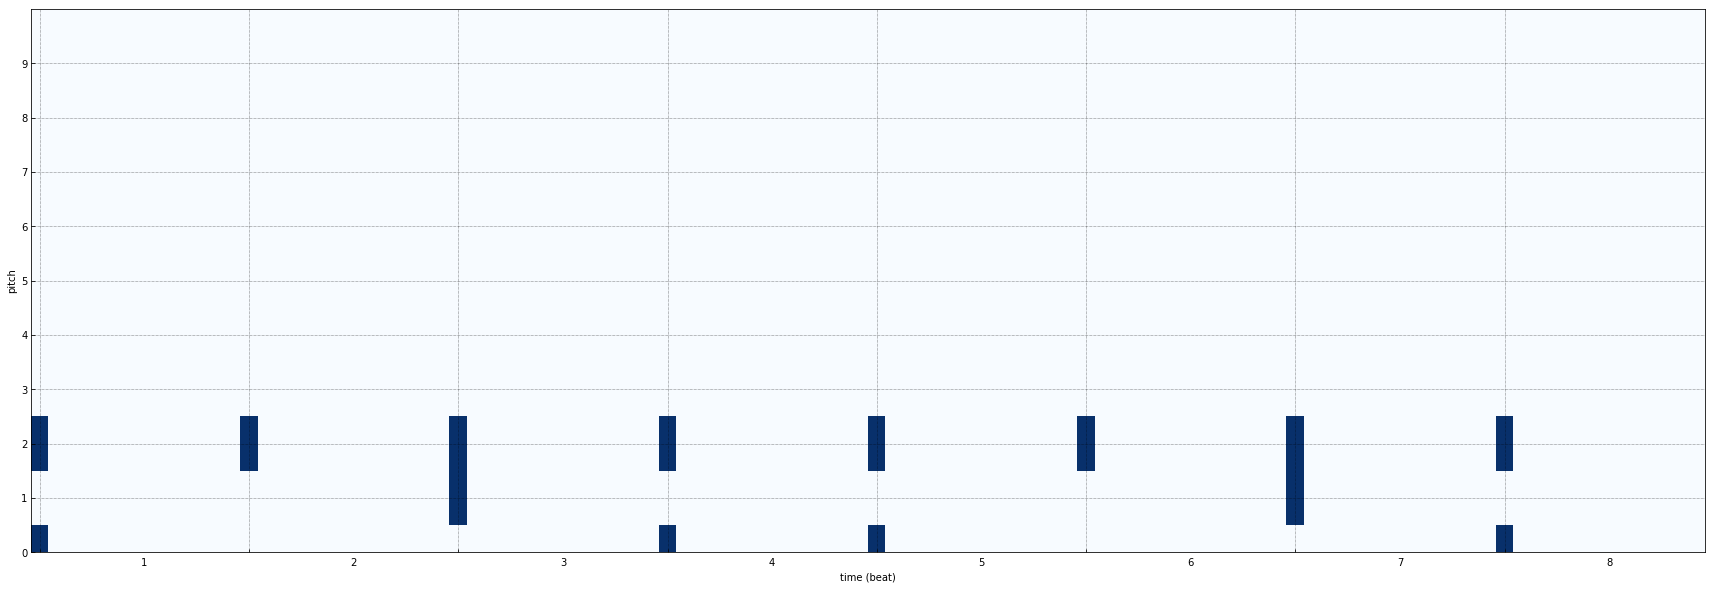

(-1, -1)
[8]________________|________________|________________|________________|________________|________________
[7]________________|________________|________________|________________|________________|________________
[6]________________|________________|________________|________________|________________|________________
[5]________________|________________|________________|________________|________________|________________
[4]________________|________________|________________|________________|________________|________________
[3]________________|________________|________________|________________|________________|________________
[2]*_______*___*___|________*_______|____*___________|*_______________|________*_______|____*___________
[1]________________|_**_____________|________________|________________|_**_____*_______|________________
[0]*_______*_______|_**_____________|____*___________|*_______________|_**_____________|____*___________
(0, -1)
[8]________________|________________|_

In [62]:

with torch.no_grad():
    data = iter(train_loader).next()[0]
#     printDrumRoll(data[0])
    pltReducedDrumTrack(data[0])

    data = Variable(data).type(torch.float32).to(device)
    latent = vae._enc_mu(encoder(data))
    out = decoder(latent)
    out_np = out.cpu().data.numpy()
    out_np = np.where(out_np > 0.2, 128, 0)

    out_concat = np.empty((0, 9))
    out_concat = np.concatenate(
        (out_concat, out_np[0]),
        axis=0)

    for i in range(9):
        x = i % 3 - 1
        y = i // 3 - 1
        print('({}, {})'.format(x, y))

        latent_shift = latent.cpu().data.numpy()
        shift = np.zeros(latent_shift.shape, dtype=np.float32)
        shift[0][2] = x * 0.2
        shift[0][3] = y * 0.2
        latent_shift = latent_shift + shift

        latent_shift = torch.from_numpy(latent_shift).to(device)
        o = decoder(latent_shift)

        o = o[0].cpu().data.numpy()
        o = np.where(o > 0.5, 1, 0)
        printDrumRoll(o)
#         pltReducedDrumTrack(o)

